__@this notebook__ will guide you through a very simple case of generative adversarial networks.

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Like.. veeery simple. Generative adversarial networks that learn to convert 1d uniform noise distribution to a uniform 1d normal data distribution.

Unlike the main notebooks (`adversarial_*.ipynb`), this one features a lot of useful visualizations that will help you both get acquainted with the behavior of two networks and debug common errors without having to wait hours of CPU time.

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

def sample_noise(batch_size):
    """ Uniform noise of shape [batch_size, 1] in range [0, 1]"""
    return torch.rand(batch_size, 1)

def sample_real_data(batch_size):
    """ Normal noise of shape [batch_size, 1], mu=5, std=1.5 """
    return torch.randn(batch_size, 1) * 1.5 + 5

In [2]:
# Generator converts 1d noise into 1d data
gen = nn.Sequential(nn.Linear(1, 16), nn.ELU(), nn.Linear(16, 1))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

# Discriminator converts 1d data into two logits (0th for real, 1st for fake). 
# It is deliberately made stronger than generator to make sure disc is slightly "ahead in the game".
disc = nn.Sequential(nn.Linear(1, 64), nn.ELU(), nn.Linear(64, 2))
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-2)

In [3]:
# we define 0-th output of discriminator as "is_fake" output and 1-st as "is_real"
IS_FAKE, IS_REAL = 0, 1

def train_disc(batch_size):
    """ trains discriminator for one step """
    
    # compute logp(real | x)
    real_data = sample_real_data(batch_size)
    logp_real_is_real = F.log_softmax(disc(real_data), dim=1)[:, IS_REAL]
    
    # compute logp(fake | G(z)). We detach to avoid computing gradinents through G(z)
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    logp_gen_is_fake = F.log_softmax(disc(gen_data), dim=1)[:, IS_FAKE]
    
    disc_loss = (-logp_real_is_real - logp_gen_is_fake).mean()
    
    # sgd step. We zero_grad first to clear any gradients left from generator training
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss.item()

In [4]:
def train_gen(batch_size):
    """ trains generator for one step """
        
    # compute logp(fake | G(z)).
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    
    logp_gen_is_real = -F.log_softmax(disc(gen_data), dim=1)[:, IS_REAL]
    
    gen_loss = logp_gen_is_real.mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss.item()

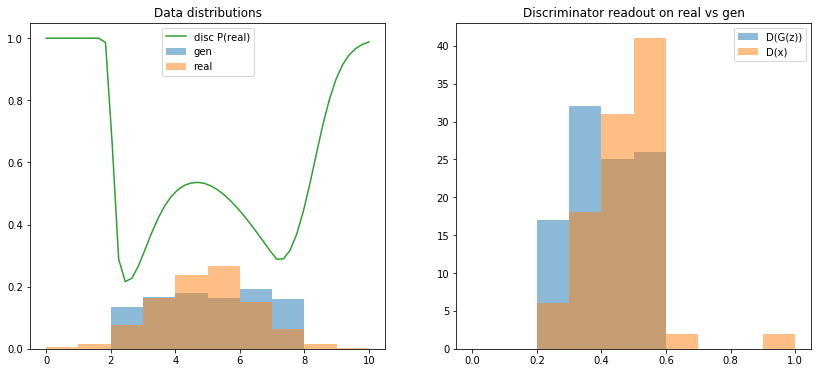

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

for i in range(100000):

    for _ in range(5):
        train_disc(128)
    
    train_gen(128)
    
    if i % 250 == 0:
        clear_output(True)
        plt.figure(figsize=[14, 6])
        plt.subplot(1, 2, 1)
        plt.title("Data distributions")
        plt.hist(gen(sample_noise(1000)).data.numpy()[:, 0],
                 range=[0, 10], alpha=0.5, normed=True, label='gen')
        plt.hist(sample_real_data(1000).data.numpy()[:,0],
                 range=[0, 10], alpha=0.5, normed=True, label='real')
        
        x = np.linspace(0, 10, dtype='float32')
        disc_preal = F.softmax(disc(torch.from_numpy(x[:, None])))[:, 1]
        plt.plot(x, disc_preal.data.numpy(), label='disc P(real)')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.title("Discriminator readout on real vs gen")
        plt.hist(F.softmax(disc(gen(sample_noise(100))))[:, 1].data.numpy(),
                 range=[0, 1], alpha=0.5, label='D(G(z))')
        plt.hist(F.softmax(disc(sample_real_data(100)))[:, 1].data.numpy(),
                 range=[0, 1], alpha=0.5, label='D(x)')
        plt.legend()
        plt.show()

__What to expect:__
* __left:__ two distributions will start differently, but generator distribution should match real data _almost_ everywhere. The curve represents discriminator's opinion on all possible values of x. It should slowly get closer to 0.5 over areas where real data is dense.
* __right:__ this chart shows how frequently does discriminator assign given probability to samples from real and generated data samples (shown in different colors). First several iterations will vary, but eventually they will both have nearly all probability mass around 0.5 as generator becomes better at it's job.
 * If instead it converges to two delta-functions around 0(gen) and 1(real) each, your discriminator has won. _Check generator loss function_. As a final measure, try decreasing discriminator learning rate. This can also happen if you replace mean over batch with sum or similar.
 * If it converges to 0.5 and stays there for several iterations but generator haven't learned to generate plausible data yet, generator is winning the game. _Double-check discriminator loss function_.